In [1]:
import numpy as np
from scipy.interpolate import interp1d

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TemporalModel from the Nanduri paper
tsample = 5e-6
tm = ec2b.TemporalModel(model='Nanduri', tsample=tsample)

# input amplitude values and expected output
exp_thresh = 30
all_amps = np.array([1.25, 1.5, 2, 4, 6]) * exp_thresh
out_amps = np.array([10, 15, 18, 19, 19])

# input frequency values and expected output
all_freqs = np.array([13, 20, 27, 40, 80, 120])
out_freqs = np.array([7.3, 10, 13, 19, 34, 51])

In [3]:
# Pulse train used in Nanduri et al. (2012)
def get_pulse_train(freq, ampl, pulse_dur=0.45/1000, dur=0.5):
    return e2cm.Psycho2Pulsetrain(freq=freq, dur=dur, 
                                  pulse_dur=pulse_dur, interphase_dur=0,
                                  delay=0.,
                                  tsample=tsample, current_amplitude=ampl, 
                                  pulsetype='cathodicfirst')

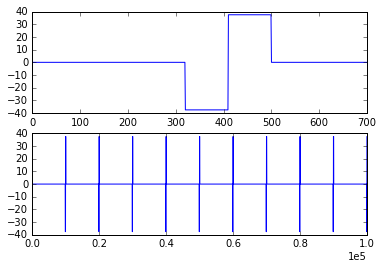

In [4]:
pulse_train = get_pulse_train(20, all_amps[0])
plt.subplot(211)
plt.plot(pulse_train.data[9500:10200])
plt.subplot(212)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot(pulse_train.data)

In [5]:
# Run the model on different amplitude values
bright_amp = []
for ampl in all_amps:
    R4 = tm.model_cascade(get_pulse_train(all_freqs[1], ampl), dojit=True)
    bright_amp.append(R4.data.max())
bright_amp = np.array(bright_amp)

# Run the model on different frequency values
bright_freq = []
for freq in all_freqs:
    R4 = tm.model_cascade(get_pulse_train(freq, all_amps[0]), dojit=True)
    bright_freq.append(R4.data.max())
bright_freq = np.array(bright_freq)

In [6]:
# Find the one scaling factor that gives the best result
seed0 = out_amps[0] / bright_amp[0]
seed1 = out_freqs[0] / bright_freq[0]
scale = np.round(np.linspace(np.min([seed0, seed1]) - 10, np.max([seed0, seed1]) + 10, 500), 3)

best_err = np.inf
best_scale = 0
for s in scale:
    err = np.sum(out_amps - s * bright_amp) ** 2 + np.sum(out_freqs - s * bright_freq) ** 2
    if err < best_err:
        best_err = err
        best_scale = s
        
print ((best_scale, best_err))

(0.97599999999999998, 10.559546167165921)


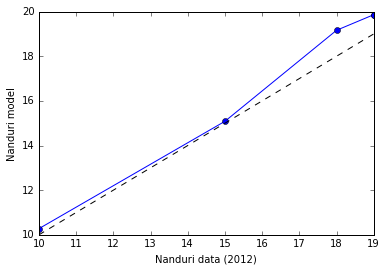

In [7]:
amp_nanduri = best_scale * bright_amp
plt.plot(out_amps, amp_nanduri, 'o-')
plt.plot([out_amps[0], out_amps[-1]], [out_amps[0], out_amps[-1]], '--k')
plt.xlabel('Nanduri data (2012)')
plt.ylabel('Nanduri model')

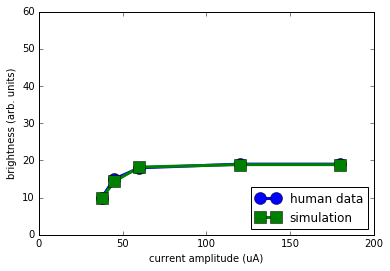

In [8]:
plt.plot(all_amps, out_amps, '-o', linewidth=3, markersize=12, label='human data')
plt.plot(all_amps, amp_nanduri*0.95, '-s', linewidth=3, markersize=12, label='simulation')
plt.xlabel('current amplitude (uA)')
plt.ylabel('brightness (arb. units)')
plt.legend(loc='lower right')
plt.ylim(0, 60)
plt.xlim(0, 200)
plt.savefig('nanduri-amps.png')

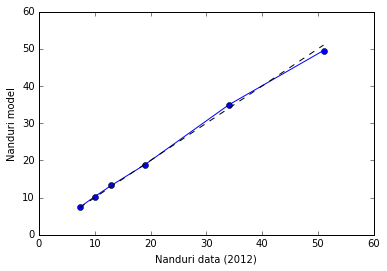

In [9]:
freq_nanduri = best_scale * bright_freq
plt.plot(out_freqs, freq_nanduri, 'o-')
plt.plot([out_freqs[0], out_freqs[-1]], [out_freqs[0], out_freqs[-1]], '--k')
plt.xlabel('Nanduri data (2012)')
plt.ylabel('Nanduri model')

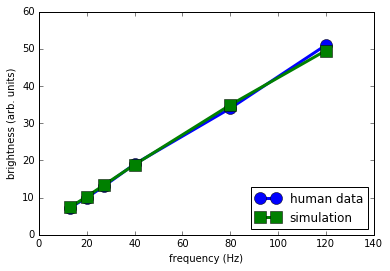

In [10]:
plt.plot(all_freqs, out_freqs, '-o', linewidth=3, markersize=12, label='human data')
plt.plot(all_freqs, freq_nanduri, '-s', linewidth=3, markersize=12, label='simulation')
plt.xlabel('frequency (Hz)')
plt.ylabel('brightness (arb. units)')
plt.legend(loc='lower right')
plt.xlim(0, 140)
plt.savefig('nanduri-freqs.png')

In [11]:
# Run the model on different amplitude values
in_amp_full = np.linspace(0, 180, 50)
bright_amp_full = []
for ampl in in_amp_full:
    R4 = tm.model_cascade(get_pulse_train(all_freqs[1], ampl), dojit=True)
    bright_amp_full.append(R4.data.max() * best_scale)
bright_amp_full = np.array(bright_amp_full)

in_freq_full = np.linspace(0, 180, 50)
bright_freq_full = []
for freq in in_freq_full:
    if freq == 0:
        bright_freq_full.append(0)
        continue

    R4 = tm.model_cascade(get_pulse_train(freq, all_amps[0]), dojit=True)
    bright_freq_full.append(R4.data.max() * best_scale)
bright_freq_full = np.array(bright_freq_full)

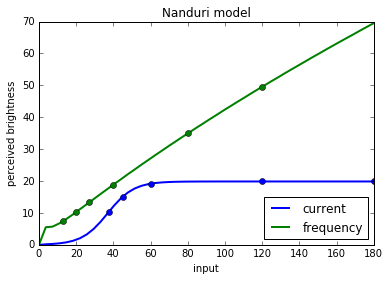

In [12]:
plt.plot(in_amp_full, bright_amp_full, 'b', linewidth=2, label='current')
plt.plot(in_freq_full, bright_freq_full, 'g', linewidth=2, label='frequency')
plt.plot(all_amps, amp_nanduri, 'ob')
plt.plot(all_freqs, freq_nanduri, 'og')
plt.xlabel('input')
plt.ylabel('perceived brightness')
plt.title('Nanduri model')
plt.legend(loc='lower right')

In [13]:
r_sampling = 250  # spatial sampling of retina
xhi = 1500
yhi = 1500
r_file = '../retina_s%d_%dx%d.npz' % (r_sampling, xhi, yhi)
r = e2cm.Retina(axon_map=r_file, sampling=r_sampling,
                xlo=-xhi, xhi=xhi, ylo=-yhi, yhi=yhi)

Can't find file ../retina_s250_1500x1500.npz, generating


In [14]:
e_all = e2cm.ElectrodeArray([260], [0], [0], [0])
ecs, cs  = r.electrode_ecs(e_all)

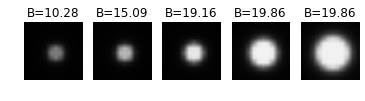

In [28]:
resp_amp = []
for i in range(len(all_amps)):
    R4 = ec2b.pulse2percept(tm, cs, r, [get_pulse_train(all_freqs[1], all_amps[i])], 
                            30, n_jobs=4, dojit=True, tol=0.05)
    plt.subplot(1, len(all_amps), i + 1)
    idx_brightest = int(R4.data.argmax() / np.prod(R4.shape[:2]))
    resp_amp.append(R4.data[..., idx_brightest])
    plt.imshow(R4.data[..., idx_brightest]  * best_scale, cmap='gray', vmin=0, vmax=21)
    plt.axis('off')
    plt.title("B={:.2f}".format(R4.data.max() * best_scale))
plt.savefig('size-amps.png')

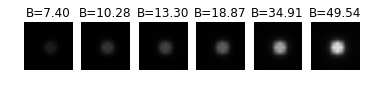

In [29]:
resp_freq = []
for i in range(len(all_freqs)):
    R4 = ec2b.pulse2percept(tm, cs, r, [get_pulse_train(all_freqs[i], all_amps[0])], 
                            30, n_jobs=4, dojit=True, tol=0.05)
    plt.subplot(1, len(all_freqs), i + 1)
    idx_brightest = int(R4.data.argmax() / np.prod(R4.shape[:2]))
    resp_freq.append(R4.data[..., idx_brightest])
    plt.imshow(R4.data[..., idx_brightest] * best_scale, cmap='gray', vmin=0, vmax=50)
    plt.axis('off')
    plt.title("B={:.2f}".format(R4.data.max() * best_scale))
plt.savefig('size-freqs.png')

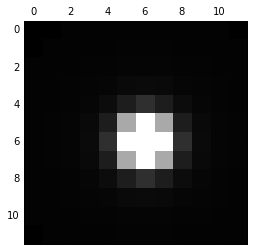

In [26]:
plt.matshow(R4.data[..., idx_brightest], cmap='gray')

In [27]:
R4.data[..., idx_brightest].sum()

519.48832756962292

In [75]:
x_a = [10.25706940874036, 11.696658097686377, 14.318766066838048, 16.169665809768638, 18.946015424164525]
y_a = [0.9571428571428573, 1.1285714285714281, 1.1285714285714281, 3.7857142857142847, 6.442857142857141]


x_fit_a = [7.789203084832906, 8.971722365038561,10.25706940874036,11.388174807197945,12.930591259640103,
           14.62724935732648,16.169665809768638,17.3521850899743,18.071979434447304,18.483290488431876,
           18.637532133676096,18.84318766066838,18.90,18.90,18.90,
           18.90,18.946015424164525,18.996,18.997,18.997,
           18.997,18.9974293059126,18.9974293059126]
y_fit_a = [1.0285714285714285, 1.0142857142857142, 1.071428571428573, 1.0857142857142854, 1.200000000000001,
           1.3428571428571434, 1.5142857142857142, 1.7142857142857153, 1.9000000000000004, 2.114285714285714,
           2.442857142857143, 2.742857142857143, 3.1571428571428575, 3.442857142857142, 3.8285714285714283,
           4.185714285714285, 4.485714285714285, 4.842857142857142, 5.1428571428571415, 5.485714285714285,
           5.785714285714285, 6.099999999999999, 6.428571428571427]

x_f = [8.868894601542417, 12.62210796915167, 17.917737789203088, 23.419023136246793, 29.074550128534707]
y_f = [1, 1, 1.1, 1.4285714285714288, 1.942857142857143]

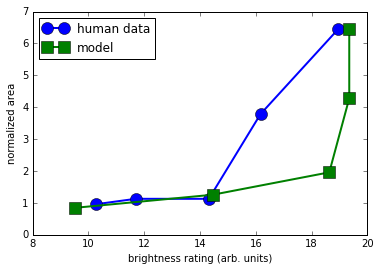

In [71]:
plt.plot(x_a, y_a, '-o', linewidth=2, markersize=12, label='human data')

xx_a = np.array([r.max() for r in resp_amp])
yy_a = np.array([r.sum() for r in resp_amp])
plt.plot(xx_a - 1, yy_a / yy_a[-1] * y_a[-1], '-s', linewidth=2, markersize=12, label='model')
plt.xlabel('brightness rating (arb. units)')
plt.ylabel('normalized area')
plt.legend(loc='upper left')
plt.savefig('area-amps.png')

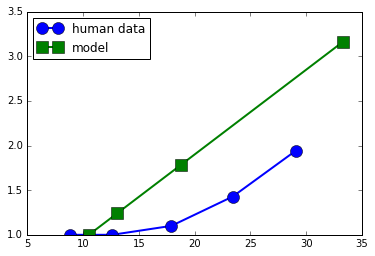

In [81]:
plt.plot(x_f, y_f, '-o', linewidth=2, markersize=12, label='human data')

xx_f = np.array([r.max() for r in resp_freq])[1:-1]
yy_f = np.array([r.sum() for r in resp_freq])[1:-1]
plt.plot(xx_f, yy_f / yy_f[0], '-s', linewidth=2, markersize=12, label='model')
plt.legend(loc='upper left')